# Is the party gap Growing?

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/party_gap.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series, frac=0.5):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, frac=frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [3]:
def plot_series_lowess(series, color, plot_series=True, frac=0.5, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    if "label" not in options:
        options["label"] = series.name

    if plot_series or len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.3, label="_")

    if not plot_series and len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.6, label=options["label"])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

In [4]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

## Read the Data

I'm using data I previous cleaned in [this notebook](https://github.com/AllenDowney/GssExtract/blob/main/notebooks/01_make_pacs_extract.ipynb).

In [5]:
from os.path import basename, exists
from pathlib import Path


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

In [6]:
download("https://github.com/AllenDowney/GssExtract/raw/main/data/interim/gss_pacs_2022.hdf")

'gss_pacs_2022.hdf'

In [7]:
gss = pd.read_hdf("gss_pacs_2022.hdf", "gss")
gss.shape

(72390, 205)

The primary variable we'll use is [polviews](https://subsetdataexplorer.norc.org/variables/178/vshow), which asks

> We hear a lot of talk these days about liberals and conservatives. I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

The points on the scale are Extremely liberal, Liberal, and Slightly liberal; Moderate;	Slightly conservative, Conservative, and Extremely conservative.

I'll clean `polviews`, replacing cases where the question was not asked or the respondent did not answer.

In [8]:
gss['partyid'].value_counts(dropna=False).sort_index()

partyid
0.0    11795
1.0    14286
2.0     8663
3.0    11540
4.0     6378
5.0    10678
6.0     7273
7.0     1292
NaN      485
Name: count, dtype: int64

In [9]:
year = gss["year"]
column = gss["partyid"]
xtab = pd.crosstab(column, year)
xtab

year,1972,1973,1974,1975,1976,1977,1978,1980,1982,1983,...,2004,2006,2008,2010,2012,2014,2016,2018,2021,2022
partyid,,,,,,,,,,,,,,,,,,,,,
0.0,326,231,246,251,225,275,216,188,382,246,...,455,700,390,348,356,419,463,379,822,595
1.0,436,383,373,349,403,400,389,374,484,382,...,504,736,331,348,343,406,496,352,541,451
2.0,160,192,207,211,207,200,199,193,243,218,...,281,527,262,265,235,337,405,307,471,400
3.0,159,143,144,211,241,175,221,246,226,192,...,471,997,322,360,373,502,473,414,817,835
4.0,100,141,106,122,105,130,135,123,152,141,...,239,327,162,197,157,249,292,259,327,330
5.0,231,218,216,236,214,226,246,218,214,256,...,425,637,303,277,250,292,364,272,384,361
6.0,126,123,110,93,96,107,111,114,137,145,...,396,495,202,184,192,245,270,255,524,431
7.0,69,62,59,12,4,5,10,9,13,13,...,29,65,38,49,54,62,72,77,114,106


[partyid](https://gssdataexplorer.norc.org/variables/141/vshow)

In [10]:
recode_partyid = {
    0: "Democrat",
    1: "Democrat",
    2: "Independent",
    3: "Independent",
    4: "Independent",
    5: "Republican",
    6: "Republican",
    7: np.nan,
}

In [11]:
gss["partyid3"] = gss["partyid"].replace(recode_partyid)
gss["partyid3"].value_counts()

partyid3
Independent    26581
Democrat       26081
Republican     17951
Name: count, dtype: int64

In [12]:
def make_diff(df):
    """Compute % liberal minus % conservative.
    """
    year = df["year"]
    column = df["partyid3"]

    xtab = pd.crosstab(year, column, normalize='index')
    diff = xtab['Democrat'] - xtab['Republican']
    
    return diff * 100

In [13]:
def make_mean(df):
    """Compute % liberal minus % conservative.
    """
    series = df.groupby('year')['polviews'].mean()
    
    return series

In [14]:
def decorate_plot(title):
    decorate(xlabel='Year',
             ylabel='% Democrat - % Republican',
             title=title)

## Make the plot with all respondents

The following functions generate a figure like the one in the FT.

In [15]:
def make_plot(df, title=''):
    """Plot % liberal - % conservative for male and female respondents.
    """
    male = df.query('sex==1')
    female = df.query('sex==2')

    diff_male = make_diff(male)
    diff_female = make_diff(female)

    plot_series_lowess(diff_male, color='C0', label='Male')
    plot_series_lowess(diff_female, color='C1', label='Female')
    decorate_plot(title)

Generate the plot for all respondents.

In [16]:
def savefig(filename, **options):
    if 'dpi' not in options:
        options['dpi'] = 300
    plt.savefig(filename, **options)

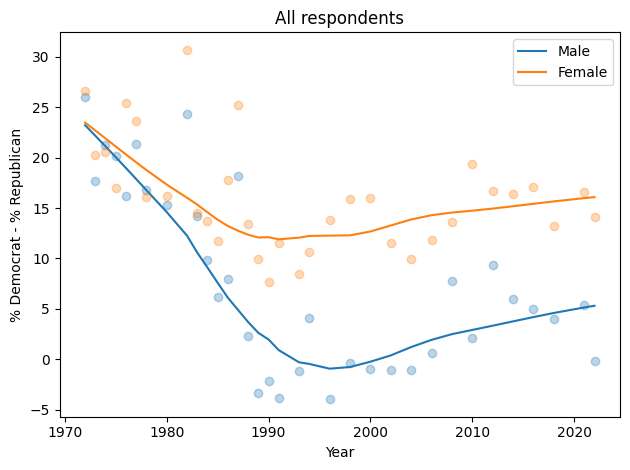

In [17]:
make_plot(gss, 'All respondents')
savefig('party_gap1.png')

In the general population, men are more likely to say they are conservative by 5-10 percentage points. 

The gap might have increased in the most recent data, depending on how seriously we take the last two points in a noisy series.

## Just young people

Now let's select just people under 30.

In [18]:
subset = gss.query('age < 30')
subset.shape

(14360, 206)

And make the same figure.

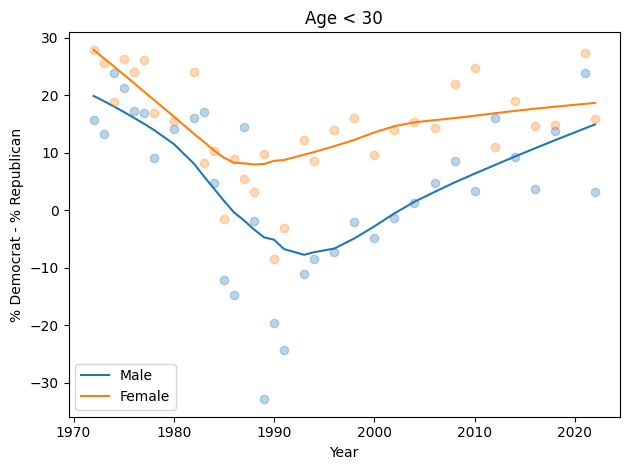

In [19]:
make_plot(subset, 'Age < 30')
savefig('party_gap2.png')

The trends here are pretty much the same as in the general population.
Men are more likely to say they are conservative, by 5-10 percentage points.

It's possible that the gap has grown in the most recent data, but the evidence is weak and depends on how we draw a smooth curve through noisy data.

Anyway, there is no evidence the trend for men is going down, and the gap in the most recent data is nowhere near 30 percentage points.

Here are the sample sizes.

In [20]:
year = subset["year"]
column = subset["sex"]
xtab = pd.crosstab(column, year)
xtab

year,1972,1973,1974,1975,1976,1977,1978,1980,1982,1983,...,2004,2006,2008,2010,2012,2014,2016,2018,2021,2022
sex,,,,,,,,,,,,,,,,,,,,,
1.0,223,180,176,181,187,175,167,142,222,182,...,253,351,157,153,155,190,228,185,177,246
2.0,177,203,204,224,201,193,240,215,274,233,...,288,415,202,222,176,198,253,213,226,307


## With Sampling Weights

In the previous figures, I have not taken into account the sampling weights.
I didn't expect them to make much difference, and they don't except for men in 2022 -- and as we'll see, there is almost certainly something wrong with that data point.

In [21]:
male = subset.query('sex==1')
female = subset.query('sex==2')

diff_male = make_diff(male)
diff_female = make_diff(female)

We only have weighted data since 1988, since that's how far back the `wtssps` variable goes.



In [22]:
recent = gss.dropna(subset=['wtssps']).query('age < 30')

In [23]:
def resample_rows_weighted(df, column):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    sample = df.sample(n=len(df), replace=True, weights=weights)
    return sample

In [24]:
def resample_by_year(df, column):
    """Resample rows within each year.

    df: DataFrame
    column: string name of weight variable

    returns DataFrame
    """
    grouped = df.groupby("year")
    samples = [resample_rows_weighted(group, column) for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample

In [25]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.

    series_seq: list of sequences
    ps: cumulative probabilities

    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, _ = array.shape

    ps = np.asarray(ps)
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [26]:
def plot_percentiles(series_seq, ps=None, label=None, **options):
    """Plot the low, median, and high percentiles.

    series_seq: sequence of Series
    ps: percentiles to use for low, medium and high
    label: string label for the median line
    options: options passed plt.plot and plt.fill_between
    """
    if ps is None:
        ps = [0.05, 0.5, 0.95]
    assert len(ps) == 3

    xs, rows = percentile_rows(series_seq, ps)
    low, med, high = rows
    plt.plot(xs, med, alpha=0.5, label=label, **options)
    plt.fill_between(xs, low, high, linewidth=0, alpha=0.2, **options)

In [27]:
def resample_diffs(df, query, iters=101):
    diffs = []
    for i in range(iters):
        sample = resample_by_year(df, "wtssps").query(query)
        diff = make_diff(sample)
        diffs.append(diff)
    return diffs

In [28]:
diffs_male = resample_diffs(recent, 'sex==1')
diffs_female = resample_diffs(recent, 'sex==2')

This figure shows the median of 101 resamplings and a 90% CI, along with the unweighted data.

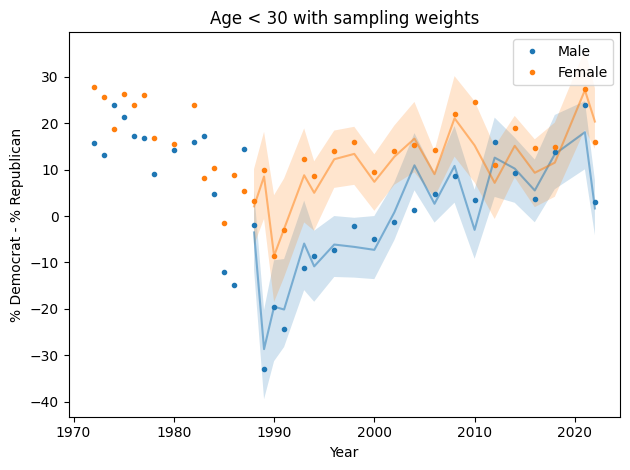

In [29]:
plot_percentiles(diffs_male)
plot_percentiles(diffs_female)

diff_male.plot(style='.', color='C0', label='Male')
diff_female.plot(style='.', color='C1', label='Female')

decorate_plot('Age < 30 with sampling weights')
savefig('party_gap3.png')

In most cases, the unweighted data falls in the CI of the weighted data, but for male respondents in 2022, the weighting moves the needle by almost 30 percentage points.

So something is not right there. I think the best option is to drop the 2022 data, but just for completeness, let's see what happens if we apply some smoothing.

## Resampling and smoothing

In [30]:
def resample_diffs_smooth(df, query, iters=101):
    diffs = []
    for i in range(iters):
        sample = resample_by_year(df, "wtssps").query(query)
        diff = make_diff(sample)
        smooth = make_lowess(diff)
        diffs.append(smooth)
    return diffs

In [31]:
diffs_male = resample_diffs_smooth(recent, 'sex==1')
diffs_female = resample_diffs_smooth(recent, 'sex==2')

Here's a version of the same plot with moderate smoothing, and dropping the unweighted data.

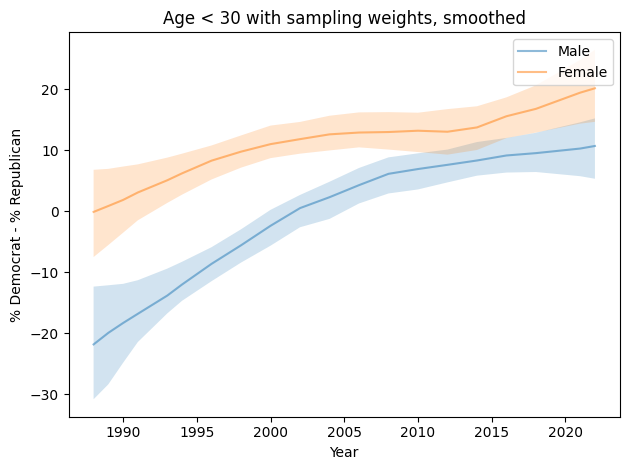

In [32]:
plot_percentiles(diffs_male, label='Male')
plot_percentiles(diffs_female, label='Female')

decorate_plot('Age < 30 with sampling weights, smoothed')
savefig('party_gap4.png')

You could make the argument that this figure shows evidence for an increasing gap, but the error bounds are very wide, and as we'll see in the next figure, the entire effect is due to the likely error in the 2022 data.

## Resampling and smoothing without 2022

Finally, here's the analysis I think is the best choice, dropping the 2022 data for both men and women.

In [33]:
pre2022 = recent.query('year < 2022')

In [34]:
diffs_male = resample_diffs_smooth(pre2022, 'sex==1')
diffs_female = resample_diffs_smooth(pre2022, 'sex==2')

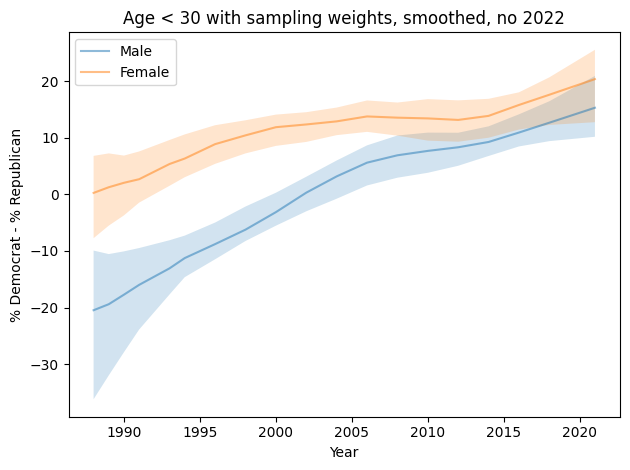

In [35]:
plot_percentiles(diffs_male, label='Male')
plot_percentiles(diffs_female, label='Female')

decorate_plot('Age < 30 with sampling weights, smoothed, no 2022')
savefig('party_gap5.png')